# Retrospective hotspotting

Recall that the "retrospective hotspot" method has no sense of time (but _often_ a sliding window of time is used, e.g. the last 8 weeks of data before the prediction date) and is a (normally grid based) KDE method.

In [ ]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

In [ ]:
south_side, points = load_data(datadir)

# Find the masked grid to use

It is definitely worth exploring how changing the offset of the grid affects prediction...

In [3]:
masked_grid = grid_for_south_side()
print("Total number of cells in region:", masked_grid.xextent * masked_grid.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid.mask))

Total number of cells in region: 2058
Number of cells which intersect geometry: 961


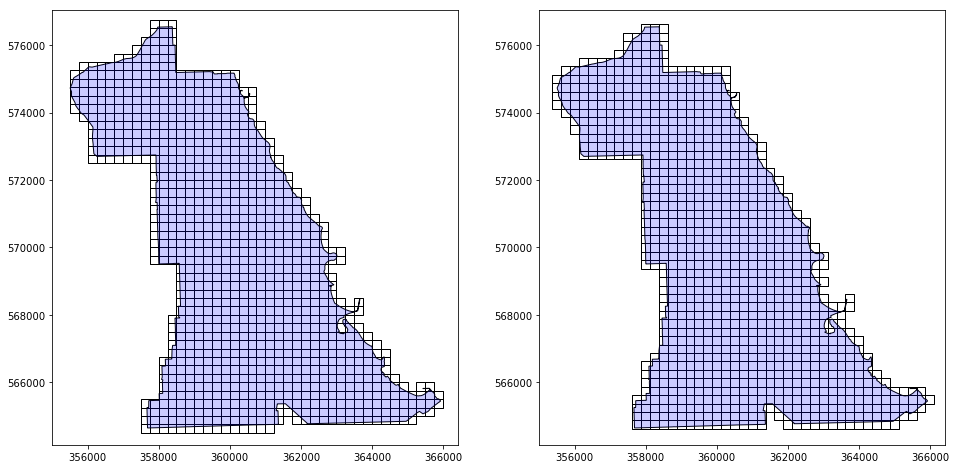

In [4]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    a.add_patch(descartes.PolygonPatch(south_side, fc="Blue", ec="none", alpha=0.2))
    xmin, ymin, xmax, ymax = south_side.bounds
    a.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(grid_for_south_side())
ax[0].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
pc = open_cp.plot.patches_from_grid(grid_for_south_side(xoffset=120, yoffset=120))
ax[1].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
None

# Comparison between grid based and continuous

In [5]:
import open_cp.retrohotspot as retro

In [6]:
cts_pred = retro.RetroHotSpot()
cts_pred.data = points
cts_pred.weight = retro.Quartic(bandwidth = 1000)
cts_risk = cts_pred.predict(end_time = np.datetime64("2011-09-28"))
cts_grid_risk = open_cp.predictors.grid_prediction(cts_risk, masked_grid)

grid_pred = retro.RetroHotSpotGrid(grid=masked_grid)
grid_pred.data = points
grid_pred.weight = retro.Quartic(bandwidth = 1000)
grid_risk = grid_pred.predict(end_time = np.datetime64("2011-09-28"))
grid_risk.mask_with(masked_grid)

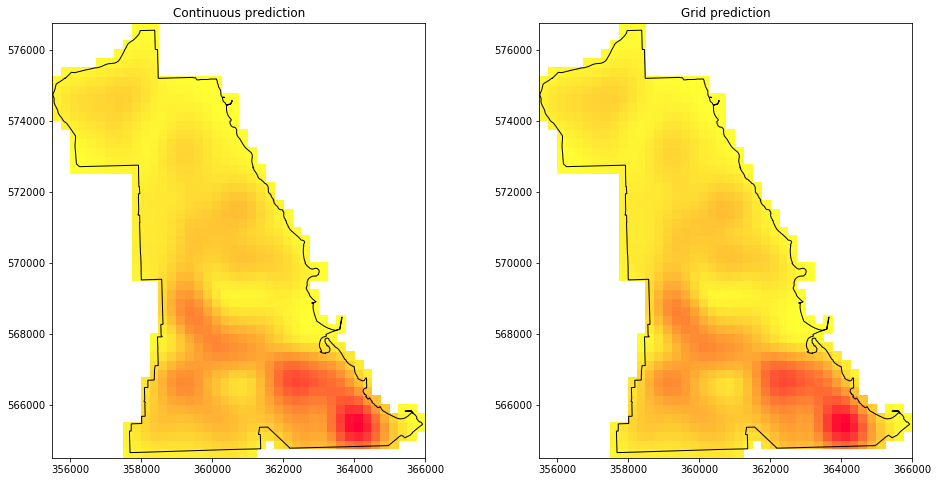

In [7]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*cts_grid_risk.mesh_data(), cts_grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Continuous prediction")
ax[1].pcolormesh(*grid_risk.mesh_data(), grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Grid prediction")
None

# Baseline hit rate

In [8]:
import open_cp.evaluation

In [9]:
class RetroHotSpot(open_cp.evaluation.PredictionProvider):
    def __init__(self, masked_grid, time_window_length = np.timedelta64(56, "D")):
        self.time_window_length = time_window_length
        self.masked_grid = masked_grid
    
    def predict(self, time):
        grid_pred = retro.RetroHotSpotGrid(grid=self.masked_grid)
        grid_pred.data = points
        grid_pred.weight = retro.Quartic(bandwidth = 1000)
        grid_risk = grid_pred.predict(start_time = time - self.time_window_length, end_time = time)
        grid_risk.mask_with(masked_grid)
        return grid_risk

evaluator = open_cp.evaluation.HitRateEvaluator(RetroHotSpot(masked_grid))
evaluator.data = points
result = evaluator.run(time_range(), range(0,51))

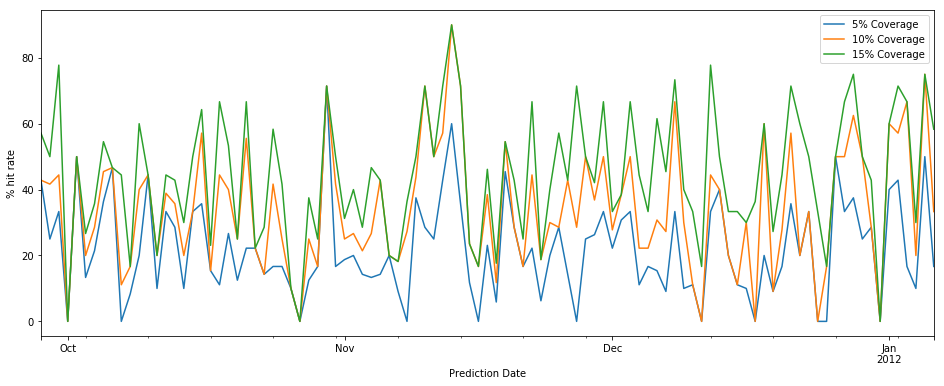

In [10]:
frame = to_dataframe(result.rates)

fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None

In [11]:
frame.describe()

% Coverage,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.0,0.058428,0.094211,0.143468,0.182115,0.219540,0.250367,0.275972,0.296387,0.318754,...,0.786373,0.800066,0.810977,0.819463,0.823896,0.833025,0.841410,0.846518,0.847343,0.858134
std,0.0,0.091692,0.104734,0.127985,0.146259,0.146781,0.153076,0.167002,0.168620,0.178851,...,0.155703,0.146743,0.144682,0.141394,0.137113,0.136176,0.138409,0.136089,0.136261,0.127632
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
25%,0.0,0.000000,0.000000,0.000000,0.083333,0.111111,0.142857,0.166667,0.187500,0.200000,...,0.714286,0.714286,0.727273,0.750000,0.750000,0.769231,0.777778,0.777778,0.777778,0.800000
50%,0.0,0.000000,0.076923,0.125000,0.166667,0.200000,0.230769,0.263158,0.285714,0.300000,...,0.800000,0.823529,0.833333,0.833333,0.833333,0.857143,0.857143,0.857143,0.857143,0.857143
75%,0.0,0.111111,0.166667,0.222222,0.285714,0.333333,0.333333,0.375000,0.416667,0.444444,...,0.888889,0.888889,0.909091,0.909091,0.916667,0.923077,0.941176,1.000000,1.000000,1.000000
max,0.0,0.400000,0.400000,0.500000,0.500000,0.714286,0.800000,0.900000,0.900000,0.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


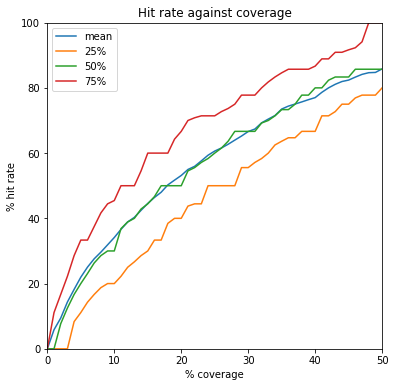

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

d = frame.describe()
ax.plot(d.columns, d.ix["mean"]*100)
ax.plot(d.columns, d.ix["25%"]*100)
ax.plot(d.columns, d.ix["50%"]*100)
ax.plot(d.columns, d.ix["75%"]*100)
ax.legend()
ax.set(ylabel="% hit rate", xlabel="% coverage")
ax.set_title("Hit rate against coverage")
ax.set(xlim=[0,50], ylim=[0,100])
None

# Show how the prediction changes over time

In [13]:
predictions = []
times = list(result.details)
times.sort()
for time in times:
    predictions.append( result.details[time].prediction )

In [14]:
from matplotlib import animation
matplotlib.rc('animation', html='html5')

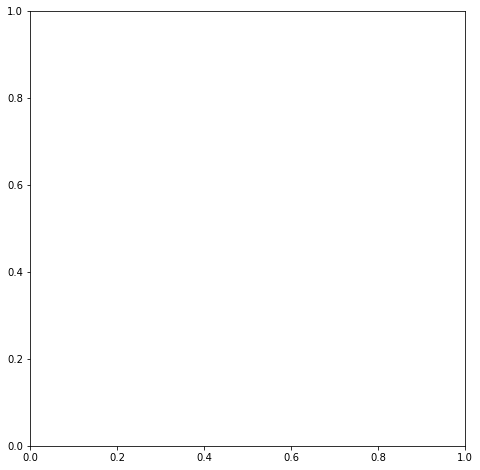

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))

In [16]:
def animator(n):
    pred = predictions[n]
    ax.collections = []
    mesh = ax.pcolormesh(*pred.mesh_data(), pred.intensity_matrix, cmap=yellow_to_red)
    ax.set_title("Risk density on {}".format(times[n]))
    return mesh

In [ ]:
animation.FuncAnimation(fig, animator, frames=len(predictions), interval=100, blit=False)

# Effect of varying the grid

We'll look at how varying the offset of the grid changes the hit rate.
- To avoid visualising massive amounts of data, we'll look at 5% coverage only

In [ ]:
# This takes a long time to run..
grid_effect = {}

for xoffset in range(0, 250, 5):
    for yoffset in range(0, 250, 5):
        masked_grid = grid_for_south_side(xoffset, yoffset)
        evaluator = open_cp.evaluation.HitRateEvaluator(RetroHotSpot(masked_grid))
        evaluator.data = points
        result = evaluator.run(time_range(), range(0,51))
        grid_effect[(xoffset, yoffset)] = result.rates

In [ ]:
import pickle
with open(os.path.join("//media", "disk", "grid_new.pic"), "wb") as f:
    grid_effect = pickle.dump(grid_effect, f)

## Here's one we prepared earlier

In [ ]:
import pickle
with open(os.path.join("//media", "disk", "grid.pic"), "rb") as f:
    grid_effect = pickle.load(f)

In [ ]:
grid_effect[(0,0)]

In [ ]:
grid_effect[(120,120)]

In [ ]:
def to_mean(result):
    frame = to_dataframe(result)
    return frame.describe()[5]["mean"]

means = { key : to_mean(value) for key, value in grid_effect.items() }

In [ ]:
first_axis_keys = set(k[0] for k in means.keys())
second_axis_keys = set(k[1] for k in means.keys())
pd.DataFrame({k:{l:means[(k,l)] for l in second_axis_keys} for k in first_axis_keys})